# Keras starter kit [full training set, UNet]

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

# Data config
DATA_DIR = '/kaggle/input/vesuvius-challenge-ink-detection/'
BUFFER = 32  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 20   # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 16  # Offset of slices in the z direction
SHARED_HEIGHT = 4000  # Height to resize all papyrii

# Model config
BATCH_SIZE = 32
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

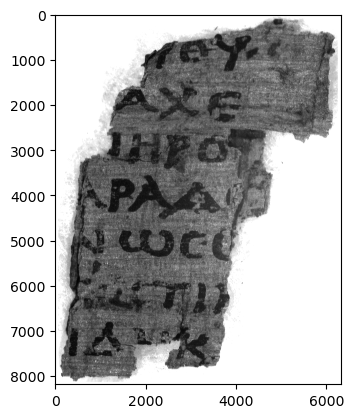

In [2]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")

## Load up the training data

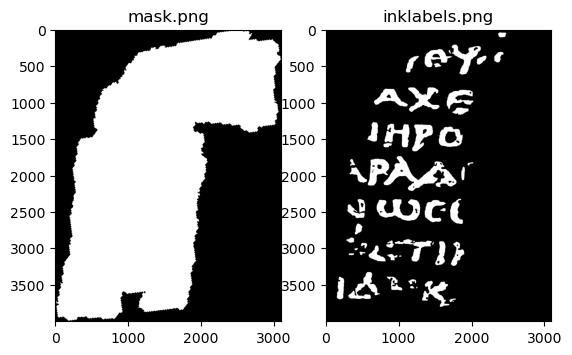

In [3]:
def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert('1')
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

def load_labels(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [4]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:3077: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


mask_test_a: (4000, 9284)
mask_test_b: (4000, 4642)
-
mask_train_1: (4000, 3094)
labels_train_1: (4000, 3094)
-
mask_train_2: (4000, 2563)
labels_train_2: (4000, 2563)
-
mask_train_3: (4000, 2760)
labels_train_3: (4000, 2760)


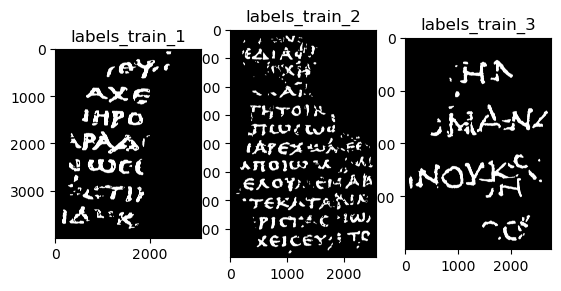

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

In [6]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        z_slice = np.array(img, dtype="float32")
        z_slices.append(z_slice)
    return tf.stack(z_slices, axis=-1)

In [7]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = tf.concat([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

del volume_train_1
del volume_train_2
del volume_train_3

20it [00:39,  1.99s/it]


volume_train_1: (4000, 3094, 20), <dtype: 'float32'>


20it [02:52,  8.64s/it]


volume_train_2: (4000, 2563, 20), <dtype: 'float32'>


20it [00:29,  1.46s/it]


volume_train_3: (4000, 2760, 20), <dtype: 'float32'>
total volume: (4000, 8417, 20)


In [8]:
labels = tf.concat([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = tf.concat([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

labels: (4000, 8417), <dtype: 'bool'>
mask: (4000, 8417), <dtype: 'bool'>


## Visualize the training data

In this case, not very informative. But remember to always visualize what you're training on, as a sanity check!

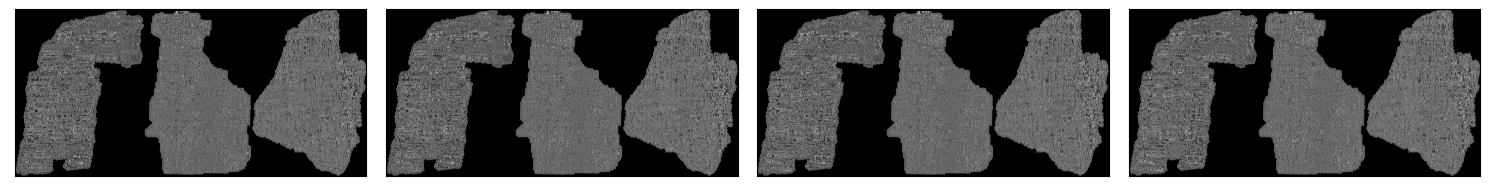

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Selection a validation holdout area

We set aside some fraction of the input to validate our model on.

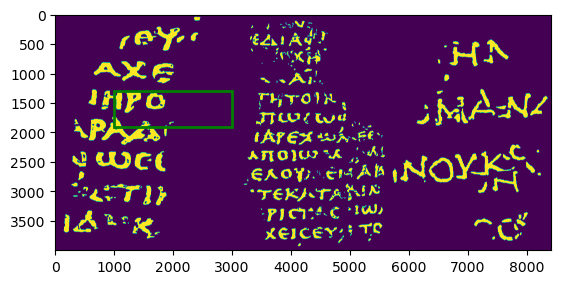

In [10]:
val_location = (1300, 1000)
val_zone_size = (600, 2000)

fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

## Create a dataset that samples random locations in the input volume

Our training dataset will grab random patches within the masked area and outside of the validation area.

In [11]:
def sample_random_location(shape):
    random_train_x = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[0] - BUFFER - 1, dtype="int32")
    random_train_y = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[1] - BUFFER - 1, dtype="int32")
    random_train_location = tf.stack([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

train_locations_ds = tf.data.Dataset.from_tensor_slices([0]).repeat().map(sample_random_location_train, num_parallel_calls=tf.data.AUTOTUNE)
train_locations_ds = train_locations_ds.filter(is_proper_train_location)

## Visualize some training patches

Sanity check visually that our patches are where they should be.

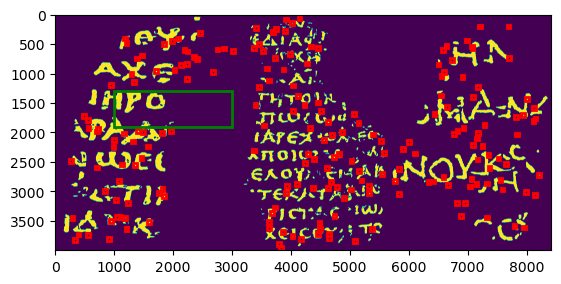

In [12]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in train_locations_ds.take(200):
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

## Create training dataset that yields random subvolumes and their labels

In [13]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = tf.cast(subvolume, dtype="float32") / 65535.
    return subvolume

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    label = tf.cast(label, dtype="float32")
    label = tf.expand_dims(label, axis=-1)
    return label

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

shuffle_buffer_size = BATCH_SIZE * 4

train_ds = train_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [14]:
for subvolume_batch, label_batch in train_ds.take(1):
    print(f"subvolume shape: {subvolume_batch.shape[1:]}")
    print(f"label_batch shape: {label_batch.shape[1:]}")

subvolume shape: (64, 64, 20)
label_batch shape: (64, 64, 1)


## Check dataset throughput

It's always a good idea to check that your data pipeline is efficient. You don't want to be CPU-bound at training time!

In [15]:
t0 = time.time()
n = 200
for _ in train_ds.take(n):
    pass
print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

Time per batch: 0.0284s


## Create validation dataset

In [16]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

val_locations_ds = tf.data.Dataset.from_tensor_slices(val_locations).filter(is_in_mask_train)
val_ds = val_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

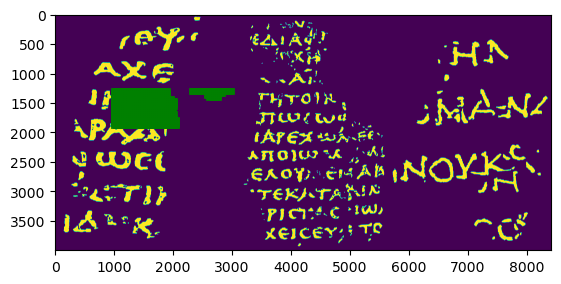

In [17]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

In [18]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        matches += tf.reduce_sum(tf.cast(batch_label, "float32"))
        total += tf.reduce_prod(tf.shape(batch_label))
    return 1. - matches / tf.cast(total, "float32")

score = trivial_baseline(val_ds).numpy()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

21it [00:03,  6.36it/s]

Best validation score achievable trivially: 76.03% accuracy


## Augment the training data

In [19]:
augmenter = keras.Sequential([
    layers.RandomContrast(0.2),
])

def augment_train_data(data, label):
    data = augmenter(data)
    return data, label

augmented_train_ds = train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

## Train a Keras model

This model is a U-Net taken from [this segmentation tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

`model.fit()` goes brrrrr

Conceptually it looks like this (animation from [this tutorial](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial)):

![animation](https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif)

In [20]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    
    x = inputs
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

if USE_MIXED_PRECISION:
    keras.mixed_precision.set_global_policy('mixed_float16')

model = get_model((BUFFER * 2, BUFFER * 2, Z_DIM))
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"], jit_compile=USE_JIT_COMPILE)

model.fit(augmented_train_ds, validation_data=val_ds, epochs=20, steps_per_epoch=1000)
model.save("model.keras")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 20)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   11584       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Clear up memory

In [21]:
del volume
del mask
del labels
del train_ds
del val_ds

# Manually trigger garbage collection
keras.backend.clear_session()
import gc
gc.collect()

model = keras.models.load_model("model.keras")

## Compute predictions on test data

In [22]:
def compute_predictions_map(split, index):
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)

    test_locations = []
    stride = BUFFER // 2
    for x in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((x, y))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    sample_random_location_test = lambda x: sample_random_location(test_mask.shape)
    is_in_mask_test = lambda x: is_in_masked_zone(x, test_mask)
    extract_subvolume_test = lambda x: extract_subvolume(x, test_volume)

    test_locations_ds = tf.data.Dataset.from_tensor_slices(test_locations).filter(is_in_mask_test)
    test_ds = test_locations_ds.map(extract_subvolume_test, num_parallel_calls=tf.data.AUTOTUNE)

    predictions_map = np.zeros(test_volume.shape[:2] + (1,), dtype="float16")
    predictions_map_counts = np.zeros(test_volume.shape[:2] + (1,), dtype="int8")

    print(f"Compute predictions")

    for loc_batch, patch_batch in tqdm(zip(test_locations_ds.batch(BATCH_SIZE), test_ds.batch(BATCH_SIZE))):
        predictions = model.predict_on_batch(patch_batch)
        for (x, y), pred in zip(loc_batch, predictions):
            predictions_map[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += pred
            predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1  
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map

In [23]:
predictions_map_a = compute_predictions_map(split="test", index="a")
predictions_map_b = compute_predictions_map(split="test", index="b")

Load data for test/a


20it [00:16,  1.24it/s]


141942 test locations (before filtering by mask)
Compute predictions


2817it [04:24, 10.65it/s]


Load data for test/b


20it [00:24,  1.24s/it]


70602 test locations (before filtering by mask)
Compute predictions


1196it [01:51, 10.73it/s]


## Resize prediction maps to their original size (for submission)

In [24]:
from skimage.transform import resize as resize_ski

original_size_a = Image.open(DATA_DIR + "/test/a/mask.png").size
predictions_map_a = resize_ski(predictions_map_a, (original_size_a[1], original_size_a[0])).squeeze()

original_size_b = Image.open(DATA_DIR + "/test/b/mask.png").size
predictions_map_b = resize_ski(predictions_map_b, (original_size_b[1], original_size_b[0])).squeeze()

## Generate submission file

In [25]:
def rle(predictions_map, threshold):
    flat_img = predictions_map.flatten()
    flat_img = np.where(flat_img > threshold, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [26]:
threshold = 0.5

rle_a = rle(predictions_map_a, threshold=threshold)
rle_b = rle(predictions_map_b, threshold=threshold)
print("Id,Predicted\na," + rle_a + "\nb," + rle_b, file=open('submission.csv', 'w'))